# POL2 Proof of Concept

This notebook is for creating a small dataset consisting of just POL2 guide cells and control cells (no guides), then performing some unsupervised and supervised training of scVI.

## Imports

In [1]:
from IPython.core.display import display, HTML
import warnings
warnings.filterwarnings('ignore')
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
repo_path = '/Users/mincheolkim/Github/'
data_path = '/Users/mincheolkim/Documents/'

In [3]:
import sys
sys.path.append(repo_path + 'scVI')
sys.path.append(repo_path + 'scVI-extensions')

In [4]:
import os

import numpy as np
from sklearn.manifold import TSNE
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage.filters import gaussian_filter
import pandas as pd
import torch
import imp
from scipy.stats import ttest_ind, wasserstein_distance, ks_2samp
from scipy.stats import norm

from scvi.metrics.clustering import entropy_batch_mixing, get_latent
from scvi.models import VAE, SVAEC, VAEC
from scvi.inference import VariationalInference

In [5]:
import scvi_extensions.dataset.supervised_data_loader as sdl
import scvi_extensions.dataset.cropseq as cs
import scvi_extensions.inference.supervised_variational_inference as svi
import scvi_extensions.hypothesis_testing.mean as mn
import scvi_extensions.dataset.label_data_loader as ldl

## Create a dataset

In [6]:
h5_filename = '/Users/mincheolkim/Documents/raw_gene_bc_matrices_h5.h5'
abridged_metadata_filename = data_path + 'batf_nc_metadata.txt'

In [7]:
imp.reload(cs)
# Load the dataset
gene_dataset = cs.CropseqDataset(
    filename=h5_filename,
    metadata_filename=abridged_metadata_filename,
    new_n_genes=1000,
    use_donors=True,
    use_labels='guide',
    save_path='')

Preprocessing CROP-seq dataset
Number of cells kept after filtering with metadata: 1400
Number of cells kept after removing all zero cells: 1400
Finished preprocessing CROP-seq dataset
Downsampling from 32738 to 1000 genes


## Useful functions

In [8]:
def plot_pair_densities(vae, inference, n_points=1000, sigma=1.5):
    latent, batch_indices, labels = get_latent(vae, inference.data_loaders['sequential'])
    latent, idx_t_sne = inference.apply_t_sne(latent, n_points)
    batch_indices = batch_indices[idx_t_sne].ravel()
    labels = labels[idx_t_sne].ravel()
    
    plt.figure(figsize=(10, 20))
    for label, guide in enumerate(inference.gene_dataset.guide_lookup):
        guide_latent = latent[labels == label, :]
        guide_heatmap, guide_xedges, guide_yedges = np.histogram2d(guide_latent[:, 0], guide_latent[:, 1], bins=30)
        guide_heatmap = gaussian_filter(guide_heatmap, sigma=sigma)
        plt.subplot(1, len(inference.gene_dataset.guide_lookup)+1, label+1)
        plt.imshow(guide_heatmap.T, extent=None, origin='lower', cmap=matplotlib.cm.jet, aspect=1)
        plt.title(guide)
    plt.show()

## Supervised training

In [9]:
n_epochs=200
lr=1e-4
use_batches=True
use_cuda=False

In [10]:
vaec = VAEC(gene_dataset.nb_genes, n_labels=gene_dataset.n_labels, n_batch=gene_dataset.n_batches * use_batches)
supervised_infer = svi.SupervisedVariationalInference(
    vaec, 
    gene_dataset, 
    train_size=0.9, 
    use_cuda=use_cuda,
    verbose=False,
    frequency=1)
supervised_infer.train(n_epochs=n_epochs, lr=lr)

training: 100%|██████████| 200/200 [03:43<00:00,  1.12s/it]


Text(0.5,0,'iter')

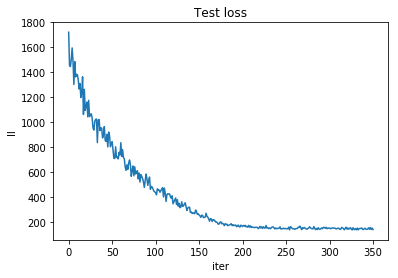

In [10]:
plt.plot(supervised_infer.history['ll_test'])
plt.title('Test loss')
plt.ylabel('ll')
plt.xlabel('iter')

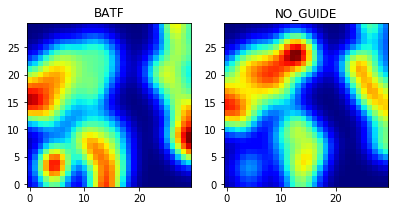

In [112]:
plot_pair_densities(vaec, supervised_infer, n_points=5000, sigma=2)

## Differential Expression

I test out some ways to perform differential expression.

First, I use scVI's method directly to compare any DE genes between BATF and control (there aren't any, in their definition)

### Default method for differential expression

In [205]:
imp.reload(mn)

<module 'scvi_extensions.hypothesis_testing.mean' from '/Users/mincheolkim/Github/scVI-extensions/scvi_extensions/hypothesis_testing/mean.py'>

In [246]:
imp.reload(ldl)
label_dataloader = ldl.LabelDataLoaders(
    gene_dataset=gene_dataset, 
    desired_labels=[0, 1], 
    num_samples=10000)

In [247]:
px_scale, all_labels = mn.expression_stats(
    vaec, 
    label_dataloader['all'], 
    M_sampling=100)

In [248]:
il_rates, il_bfs = mn.get_bayes_factors(0, 1, px_scale, all_labels)
wl_rates, wl_bfs = mn.get_bayes_factors(1, 1, px_scale, all_labels, null=True)

In [249]:
print('Most positive bayes factor', il_bfs.max())
print('Most negative bayes factor', il_bfs.min())
print('Nothing seems significant!')

Most positive bayes factor 0.8439667257596161
Most negative bayes factor -1.1028834909897718
Nothing seems significant!


In [266]:
print(
    'Most DE gene:', 
    gene_dataset.gene_names[np.where(il_bfs == il_bfs.min())[0][0]])

Most DE gene: HLA-A


### Looking at distribution of Bayes factors for a gene and cell type

In [252]:
imp.reload(mn)
h1_bayes_factors, h0_bayes_factors = mn.batch_differential_expression(
    vaec, 
    label_dataloader['all'], 
    M_sampling=100, 
    desired_labels=[0, 1], 
    num_batch=100)

In [253]:
print('Gene of interest is HLA-A at index', np.where(gene_dataset.gene_names == 'HLA-A')[0][0])

Gene of interest is HLA-A at index 103


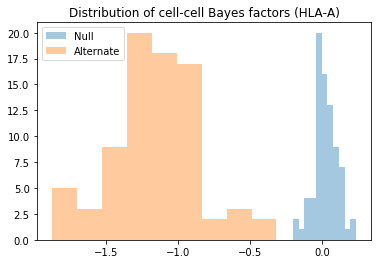

In [254]:
sns.distplot(h0_bayes_factors[:, 103], kde=False)
sns.distplot(h1_bayes_factors[:, 103], kde=False)
plt.legend(['Null', 'Alternate']);
plt.title('Distribution of cell-cell Bayes factors (HLA-A)');

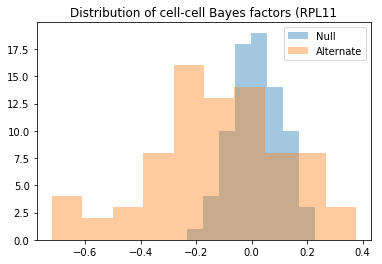

In [255]:
sns.distplot(h0_bayes_factors[:, 55], kde=False)
sns.distplot(h1_bayes_factors[:, 55], kde=False)
plt.legend(['Null', 'Alternate']);
plt.title('Distribution of cell-cell Bayes factors (RPL11');

### Getting a p-values

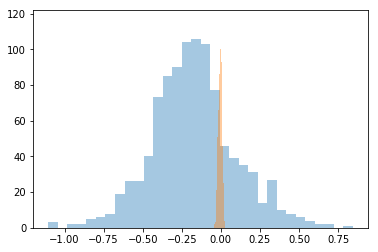

In [256]:
sns.distplot(il_bfs, kde=False)
sns.distplot(wl_bfs, kde=False)

Text(0,0.5,'Gene count')

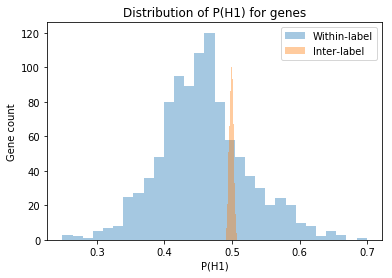

In [257]:
sns.distplot(il_rates, kde=False)
sns.distplot(wl_rates, kde=False)
plt.title('Distribution of P(H1) for genes')
plt.legend(['Within-label', 'Inter-label'])
plt.xlabel('P(H1)')
plt.ylabel('Gene count')

### Differential Expression code

In [276]:
imp.reload(mn)

<module 'scvi_extensions.hypothesis_testing.mean' from '/Users/mincheolkim/Github/scVI-extensions/scvi_extensions/hypothesis_testing/mean.py'>

In [278]:
de_results = mn.differential_expression(vaec, gene_dataset, [0, 1], 100, 10000)

In [281]:
de_results[0][1].head(5)

,gene,P(H1),bayes_factor,bayes_factor_mag,pval,direction
139,HLA-C,0.2461,-1.119522,1.119522,0.0,-1.0
826,SNX6,0.2497,-1.100213,1.100213,0.0,-1.0
754,CLEC2B,0.2539,-1.077919,1.077919,0.0,-1.0
103,HLA-A,0.2548,-1.073174,1.073174,0.0,-1.0
413,PRR13,0.2609,-1.041296,1.041296,0.0,-1.0
